In [1]:
%pip install ribs[all] gym~=0.17.0 p tqdm

zsh:1: no matches found: ribs[all]
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
sys.path.append('/opt/miniconda3/lib/python3.10/site-packages')

import gym
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
env = gym.make("LunarLander-v2")
seed = 1339
action_dim = env.action_space.n
obs_dim = env.observation_space.shape[0]

In [4]:
def simulate(env, model, seed=None):
    """Simulates the lunar lander model.

    Args:
        env (gym.Env): A copy of the lunar lander environment.
        model (np.ndarray): The array of weights for the linear policy.
        seed (int): The seed for the environment.
    Returns:
        total_reward (float): The reward accrued by the lander throughout its
            trajectory.
        impact_x_pos (float): The x position of the lander when it touches the
            ground for the first time.
        impact_y_vel (float): The y velocity of the lander when it touches the
            ground for the first time.
    """
    if seed is not None:
        env.seed(seed)

    action_dim = env.action_space.n
    obs_dim = env.observation_space.shape[0]
    model = model.reshape((action_dim, obs_dim))

    total_reward = 0.0
    impact_x_pos = None
    impact_y_vel = None
    all_y_vels = []
    obs = env.reset()
    done = False

    while not done:
        action = np.argmax(model @ obs)  # Linear policy.
        obs, reward, done, info = env.step(action)
        total_reward += reward

        # Refer to the definition of state here:
        # https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py#L306
        x_pos = obs[0]
        y_vel = obs[3]
        leg0_touch = bool(obs[6])
        leg1_touch = bool(obs[7])
        all_y_vels.append(y_vel)

        # Check if the lunar lander is impacting for the first time.
        if impact_x_pos is None and (leg0_touch or leg1_touch):
            impact_x_pos = x_pos
            impact_y_vel = y_vel

    # If the lunar lander did not land, set the x-pos to the one from the final
    # timestep, and set the y-vel to the max y-vel (we use min since the lander
    # goes down).
    if impact_x_pos is None:
        impact_x_pos = x_pos
        impact_y_vel = min(all_y_vels)

    return total_reward, impact_x_pos, impact_y_vel

In [5]:
from ribs.archives import GridArchive

archive = GridArchive(
    [50, 50],  # 50 bins in each dimension.
    [(-1.0, 1.0), (-3.0, 0.0)],  # (-1, 1) for x-pos and (-3, 0) for y-vel.
)

In [6]:
from ribs.emitters import ImprovementEmitter

initial_model = np.zeros((action_dim, obs_dim))
emitters = [
    ImprovementEmitter(
        archive,
        initial_model.flatten(),
        1.0,  # Initial step size.
        batch_size=30,
    ) for _ in range(5)  # Create 5 separate emitters.
]

In [7]:
from ribs.optimizers import Optimizer

optimizer = Optimizer(archive, emitters)

In [8]:
start_time = time.time()
total_itrs = 500

for itr in tqdm(range(1, total_itrs + 1)):
    # Request models from the optimizer.
    sols = optimizer.ask()

    # Evaluate the models and record the objectives and BCs.
    objs, bcs = [], []
    for model in sols:
        obj, impact_x_pos, impact_y_vel = simulate(env, model, seed)
        objs.append(obj)
        bcs.append([impact_x_pos, impact_y_vel])

    # Send the results back to the optimizer.
    optimizer.tell(objs, bcs)

    # Logging.
    if itr % 25 == 0:
        elapsed_time = time.time() - start_time
        print(f"> {itr} itrs completed after {elapsed_time:.2f} s")
        print(f"  - Archive Size: {len(archive)}")
        print(f"  - Max Score: {archive.stats.obj_max}")

  0%|          | 0/500 [00:00<?, ?it/s]

> 25 itrs completed after 182.13 s
  - Archive Size: 1181
  - Max Score: 269.13466473853964
> 50 itrs completed after 529.76 s
  - Archive Size: 1680
  - Max Score: 282.081700641182
> 75 itrs completed after 735.63 s
  - Archive Size: 2132
  - Max Score: 282.081700641182
> 100 itrs completed after 858.95 s
  - Archive Size: 2306
  - Max Score: 282.081700641182
> 125 itrs completed after 974.74 s
  - Archive Size: 2388
  - Max Score: 282.081700641182
> 150 itrs completed after 1125.19 s
  - Archive Size: 2461
  - Max Score: 282.081700641182
> 175 itrs completed after 1304.50 s
  - Archive Size: 2478
  - Max Score: 282.081700641182
> 200 itrs completed after 1488.80 s
  - Archive Size: 2483
  - Max Score: 282.081700641182
> 225 itrs completed after 1932.84 s
  - Archive Size: 2487
  - Max Score: 282.081700641182
> 250 itrs completed after 2465.70 s
  - Archive Size: 2491
  - Max Score: 282.081700641182
> 275 itrs completed after 2729.67 s
  - Archive Size: 2491
  - Max Score: 284.6111093

Text(0.5, 0, 'Impact x-position')

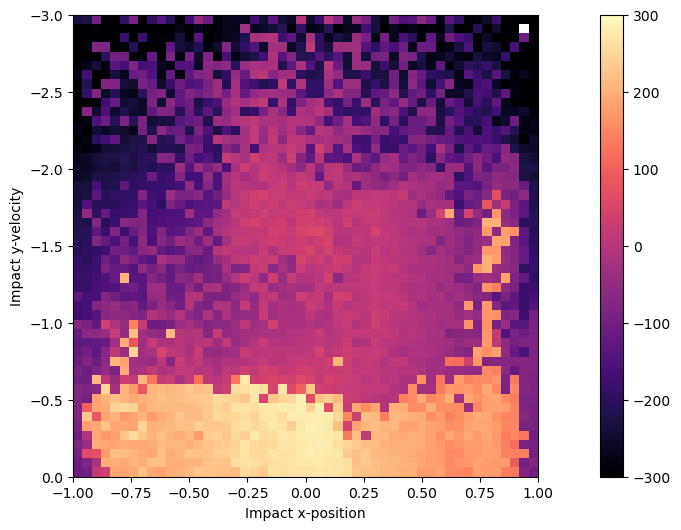

In [9]:
from ribs.visualize import grid_archive_heatmap

plt.figure(figsize=(8, 6))
grid_archive_heatmap(archive, vmin=-300, vmax=300)
plt.gca().invert_yaxis()  # Makes more sense if larger velocities are on top.
plt.ylabel("Impact y-velocity")
plt.xlabel("Impact x-position")

In [10]:
try:
    # In Google Colab, it is necessary to set up a virtual display so that
    # OpenAI Gym can render properly.

    import google.colab
    print("Google Colab detected. Setting up virtual display.")

    !apt-get install -y xvfb python-opengl
    %pip install pyvirtualdisplay

    from pyvirtualdisplay import Display

    display = Display(visible=0, size=(400, 300))
    display.start()
except ImportError:
    print("Not in Google Colab. Skipping display setup.")

Not in Google Colab. Skipping display setup.


In [18]:
import base64
import glob
import io

from IPython.display import display, HTML

sys.path.append("/opt/anaconda3/lib/python3.9/site-packages")


def display_video(model):
    """Displays a video of the model in the environment."""

    # Monitor records a video of the environment.
    video_env = gym.wrappers.Monitor(
        gym.make("LunarLander-v2"),
        "videos",  # Video directory.
        force=True,  # Overwrite existing videos.
        video_callable=lambda idx: True,  # Make all episodes be recorded.
    )
    simulate(video_env, model, seed)
    video_env.close()  # Save video.

    # Display the video with HTML. Though we use glob, there is only 1 video.
    for video_file in glob.glob("videos/*.mp4"):
        video = io.open(video_file, 'rb').read()
        encoded = base64.b64encode(video).decode("ascii")
        display(
            HTML(f'''
            <video width="360" height="auto" controls>
                <source src="data:video/mp4;base64,{encoded}" type="video/mp4" />
            </video>'''))